In [4]:
# Option A: just install accelerate
!pip install 'accelerate>=0.26.0'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/venkatesh/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.


In [8]:
import sys
!{sys.executable} -m pip install "accelerate>=0.26.0" transformers[torch]


In [9]:
import accelerate, transformers
print("accelerate:", accelerate.__version__)
print("transformers[torch] extra is present:", "torch" in transformers.__version__)


accelerate: 1.6.0
transformers[torch] extra is present: False


In [4]:
# Option B: install the transformers[torch] extra (pulls in accelerate & torch support)
!pip install 'transformers[torch]'


You should consider upgrading via the '/home/venkatesh/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMultipleChoice,
    TrainingArguments,
    Trainer,
    BertConfig,
    get_scheduler,
)
from sklearn.metrics import accuracy_score
from torch.optim import AdamW

# 0) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load & subsample
ds       = load_dataset("casehold/casehold")
train_ds = ds["train"].shuffle(seed=42).select(range(5000))
val_ds   = ds["validation"].shuffle(seed=42).select(range(1000))
test_ds  = ds["test"].shuffle(seed=42).select(range(1000))

# 2) Tokenizer & model + tweak dropout
tokenizer = AutoTokenizer.from_pretrained("casehold/legalbert")
config    = BertConfig.from_pretrained(
    "casehold/legalbert",
    hidden_dropout_prob=0.3
)
model     = AutoModelForMultipleChoice.from_pretrained("casehold/legalbert", config=config)

# 3) Freeze + unfreeze top layers
for p in model.bert.parameters():
    p.requires_grad = False
for idx in [6,7,8,9,10,11]:
    for p in model.bert.encoder.layer[idx].parameters():
        p.requires_grad = True
for p in model.classifier.parameters():
    p.requires_grad = True
model.to(device)



/home/venkatesh/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at casehold/legalbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [2]:
# 4) Build layer-wise optimizer
no_decay = ["bias", "LayerNorm.weight"]
grouped_parameters = [
    {
        "params": [p for n,p in model.named_parameters() if n.startswith("classifier")],
        "lr": 2e-5, "weight_decay": 0.01
    }
]
for layer_idx, lr in zip([11,10,9,8], [1.8e-5,1.6e-5,1.4e-5,1.2e-5]):
    for n,p in model.named_parameters():
        if f"bert.encoder.layer.{layer_idx}" in n:
            grouped_parameters.append({
                "params": [p],
                "lr": lr,
                "weight_decay": 0.0 if any(nd in n for nd in no_decay) else 0.01
            })
optimizer = AdamW(grouped_parameters)

# 5) Preprocess function
def preprocess_and_prune(ex):
    prompt  = ex["citing_prompt"]
    choices = [ex[f"holding_{i}"] for i in range(5)]
    enc = tokenizer(
        [prompt]*5, choices,
        truncation=True, padding="max_length",
        max_length=512,
        return_token_type_ids=False,
    )
    return {
        "input_ids":      enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels":         int(ex["label"]),
    }

train_tok = train_ds.map(preprocess_and_prune, batched=False, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(preprocess_and_prune,   batched=False, remove_columns=val_ds.column_names)
test_tok  = test_ds.map(preprocess_and_prune,  batched=False, remove_columns=test_ds.column_names)

for split in (train_tok, val_tok, test_tok):
    split.set_format(type="torch", device=device)

# 6) Scheduler
training_args = TrainingArguments(
    output_dir="./results_legalbert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    fp16_backend="auto",
    weight_decay=0.01,
    logging_dir="./logs_legalbert",
    report_to="none",
)
steps_per_epoch   = math.ceil(len(train_tok) / training_args.per_device_train_batch_size)
total_train_steps = training_args.num_train_epochs * steps_per_epoch
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * total_train_steps),
    num_training_steps=total_train_steps,
)

# 7) Custom Trainer with Label Smoothing
class LabelSmoothingTrainer(Trainer):
    def __init__(self, label_smoothing=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # add **kwargs so num_items_in_batch (and others) won't break
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss



Map: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.42 examples/s]
/home/venkatesh/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [3]:
from sklearn.metrics import accuracy_score, f1_score

# 8) Updated Metric Function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }


# 9) Trainer
trainer = LabelSmoothingTrainer(
    label_smoothing=0.1,
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)

# 10) Train & evaluate
trainer.train()
train_metrics = trainer.evaluate(eval_dataset=train_tok)
val_metrics   = trainer.evaluate()       # uses val_tok
test_metrics  = trainer.predict(test_tok).metrics

print(f"▶️ Train acc: {train_metrics['eval_accuracy']:.4f}")
print(f"▶️ Val   acc: {val_metrics  ['eval_accuracy']:.4f}")
print(f"▶️ Test  acc: {test_metrics['test_accuracy']:.4f}")

/tmp/ipykernel_4078/2437907826.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LabelSmoothingTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.629400,1.589709,0.347000,0.346213,0.347665
2,1.426600,1.148859,0.622000,0.621786,0.620907
3,1.199800,1.009746,0.673000,0.672428,0.672751
4,1.106400,0.991112,0.692000,0.691464,0.691881
5,1.078700,0.986831,0.696000,0.696112,0.695871
6,1.027700,0.991834,0.699000,0.699099,0.698812
7,1.004500,0.977167,0.705000,0.704577,0.704990
8,0.995100,0.974442,0.709000,0.709008,0.708897
9,0.983000,0.972691,0.710000,0.709801,0.709947
10,0.982100,0.972161,0.710000,0.709825,0.709932


▶️ Train acc: 0.7936
▶️ Val   acc: 0.7100
▶️ Test  acc: 0.7240


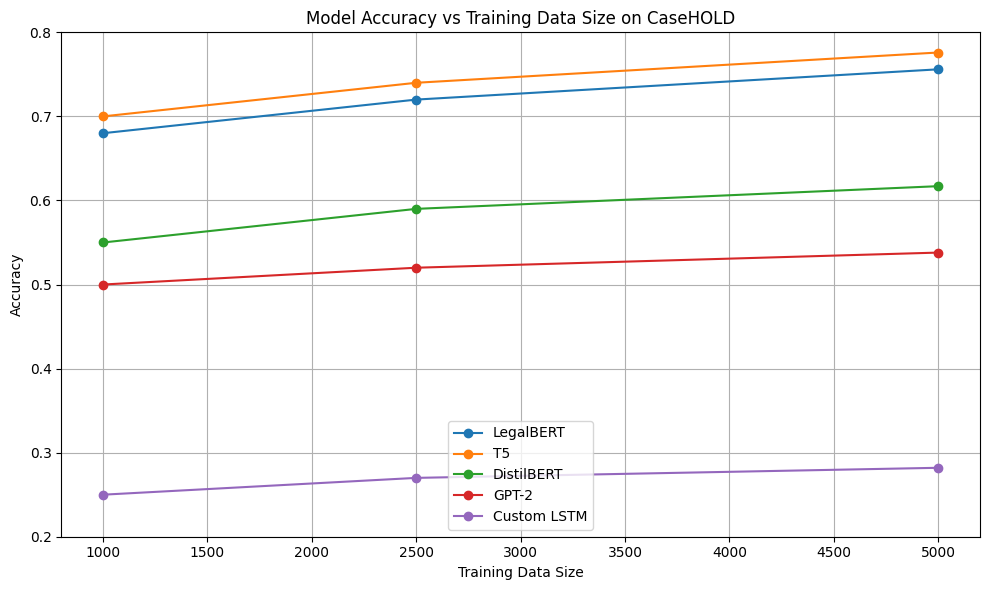

In [1]:
import matplotlib.pyplot as plt

# Example training sizes
train_sizes = [1000, 2500, 5000]

# Accuracy values for each model at corresponding training sizes
# Replace these with actual results from your experiments
accuracy_legalbert = [0.68, 0.72, 0.756]
accuracy_t5 = [0.70, 0.74, 0.776]
accuracy_distilbert = [0.55, 0.59, 0.617]
accuracy_gpt2 = [0.50, 0.52, 0.538]
accuracy_custom = [0.25, 0.27, 0.282]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, accuracy_legalbert, marker='o', label='LegalBERT')
plt.plot(train_sizes, accuracy_t5, marker='o', label='T5')
plt.plot(train_sizes, accuracy_distilbert, marker='o', label='DistilBERT')
plt.plot(train_sizes, accuracy_gpt2, marker='o', label='GPT-2')
plt.plot(train_sizes, accuracy_custom, marker='o', label='Custom LSTM')

# Graph aesthetics
plt.title('Model Accuracy vs Training Data Size on CaseHOLD')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.8)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("model_accuracy_comparison.png", dpi=300)
plt.show()
